In [1]:
from qutip import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

In [2]:
X = sigmax()
Y = sigmay()
Z = sigmaz()
I = qeye(2)

def Isingx(N, edges, h=1):
    global X,Y,Z,I
    matrices = [I for i in range(N)]
    sumsigmax = 0
    sumsigmazz = 0
    if type(h) is int:
        h *= np.ones(N)
#     if type(J) is int:
#         J *= np.ones(len(edges))        
    for i in range(N):
        matrices[i] = X
        sumsigmax += h[i]*tensor(matrices)
        matrices[i] = I
    for i in range(len(edges)):
        matrices[edges[i][0]] = Z
        matrices[edges[i][1]] = Z
        sumsigmazz += edges[i][2]*tensor(matrices)
        matrices[edges[i][0]] = I
        matrices[edges[i][1]] = I  
    H = sumsigmazz + sumsigmax
    return H


def Hxxx(N, edges, h=1):
    global X,Y,Z,I
    matrices = [I for i in range(N)]
    sumsigmaz = 0
    sumsigmaxx = 0
    sumsigmayy = 0
    sumsigmazz = 0
    if type(h) is int:
        h *= np.ones(N)
#     if type(J) is int:
#         J *= np.ones(len(edges))        
    for i in range(N):
        matrices[i] = Z
        sumsigmaz += h[i]*tensor(matrices)
        matrices[i] = I    
    for i in range(len(edges)):
        matrices[edges[i][0]] = X
        matrices[edges[i][1]] = X
        sumsigmaxx += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Y
        matrices[edges[i][1]] = Y
        sumsigmayy += edges[i][2]*tensor(matrices)
#         matrices[edges[i][0]] = I
#         matrices[edges[i][1]] = I
        matrices[edges[i][0]] = Z
        matrices[edges[i][1]] = Z
        sumsigmazz += edges[i][2]*tensor(matrices)
        matrices[edges[i][0]] = I
        matrices[edges[i][1]] = I  
    H = sumsigmaxx+sumsigmazz+sumsigmayy+ sumsigmaz
    return H

def excstate(N):
    up = tensor([basis(2,1) for n in range(N)])
    state = up*up.dag()
    return state

def charge(H0, Htot, ancilla, target, tracekeep, times):
    fidel = []
    ergotropy = []
    t = np.linspace(0,1,100)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red0 = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red0*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    for r in range(times):
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        ergotropy.append(W0 - np.sum(RsystEigVal*HsystEigEn)) 
        fidel.append(fidelity(target,Rsyst_red))
        Rin=tensor(ancilla,Rsyst_red)
    return ergotropy, fidel 

In [3]:
h = 1 
N0 = 4
times, realizations = 100 , 5
mu = 0
# sigma = np.arange(0.1,0.9,0.1)
t = np.linspace(0,1,100)

Jall = np.array([[1,1,1,1], [-1,-1,-1,-1], [-1,1,-1,1], [1,1,-1,1], [-1,-1,1,-1]])
J = Jall[-1]
g, p = Jall[0], Jall[0]

edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,1,J[3]]]
edges1 = [[0,1,g[0]],[1,2,J[0]],[2,3,J[1]],[3,4,J[2]],[4,1,J[3]]]
edges20= [[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
edges21= [[0,1,p[0]],[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
edges30= [[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
edges33= [[0,1,p[0]],[1,2,p[1]],[2,0,p[2]],[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
edges40= [[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]
edges44= [[0,1,p[0]],[1,2,p[1]],[2,3,p[2]],[3,1,p[3]],[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]

* Battery: Heisenberg with Fixed J Configurations on Rotation
* Charger: Uniform Environment
* Fidelity and Ergotropy Calculation

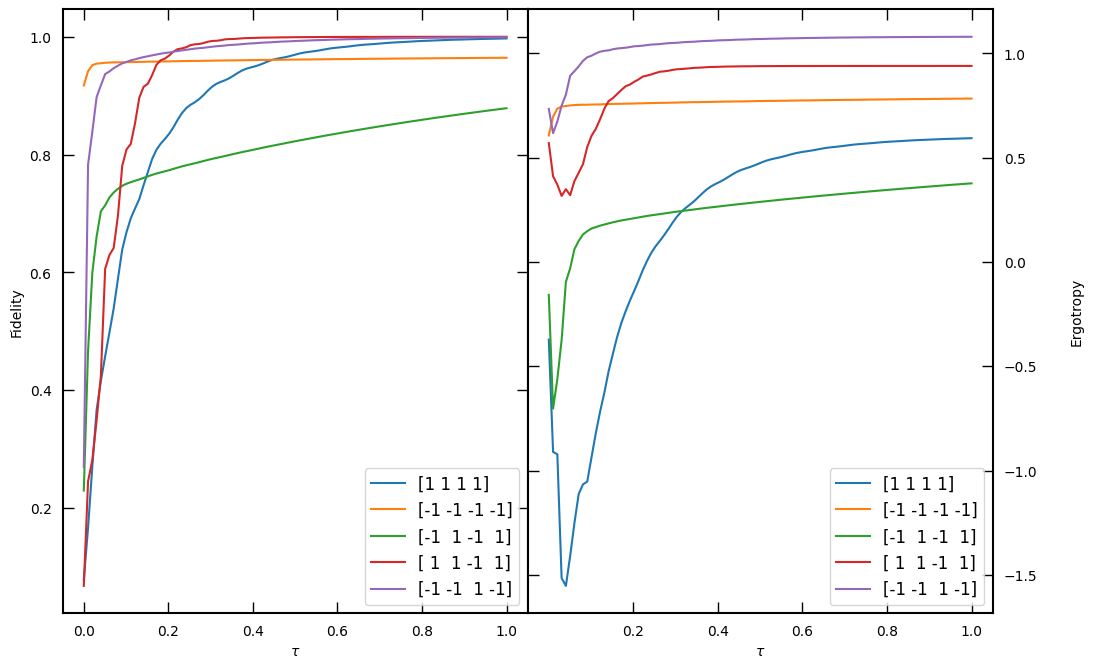

In [4]:
#1-0

N = 5 

fidelity1 = np.zeros(shape=(realizations, times))
ergotropy1 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges1 = [[0,1,g[0]],[1,2,J[0]],[2,3,J[1]],[3,4,J[2]],[4,1,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges1, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx = ((i+1)%4+1)  
        edges1 = [[0,conn_idx,g[0]],[1,2,J[0]],[2,3,J[1]],[3,4,J[2]],[4,1,J[3]]] 
        Htot = Hxxx(N, edges1, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy1[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity1[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity1[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy1[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

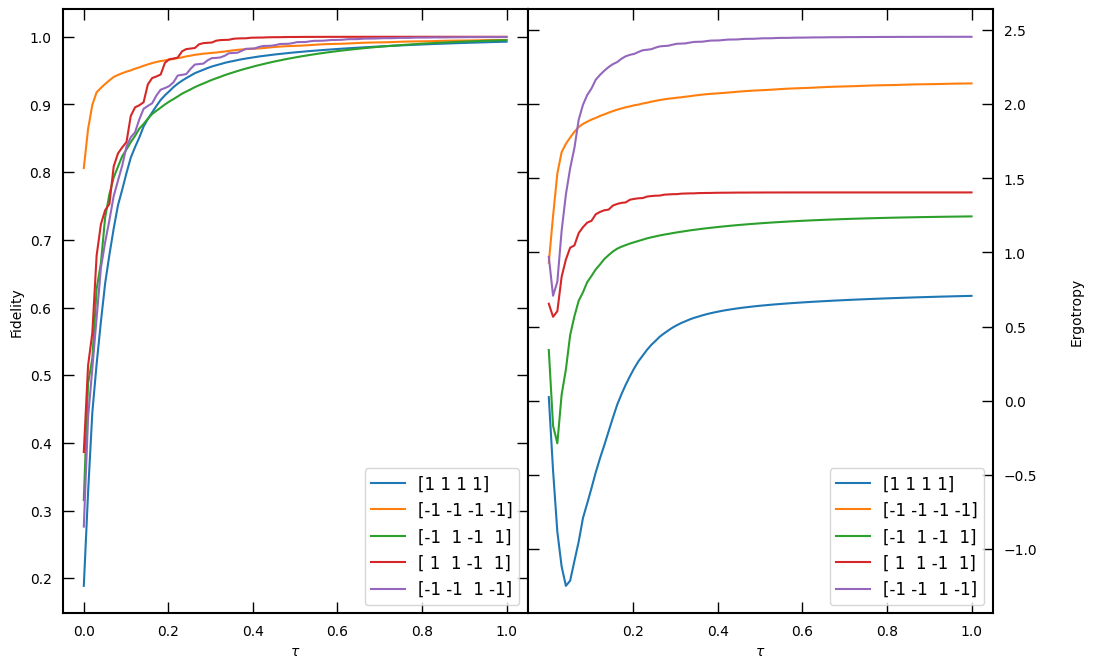

In [5]:
#2-0

N = 6

fidelity20 = np.zeros(shape=(realizations, times))
ergotropy20 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges20= [[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges20, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2 = ((i+1)%4+2), ((i+2)%4+2)
        edges20= [[0,conn_idx1,g[0]],[1,conn_idx1,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
        Htot = Hxxx(N, edges20, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy20[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity20[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity20[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy20[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

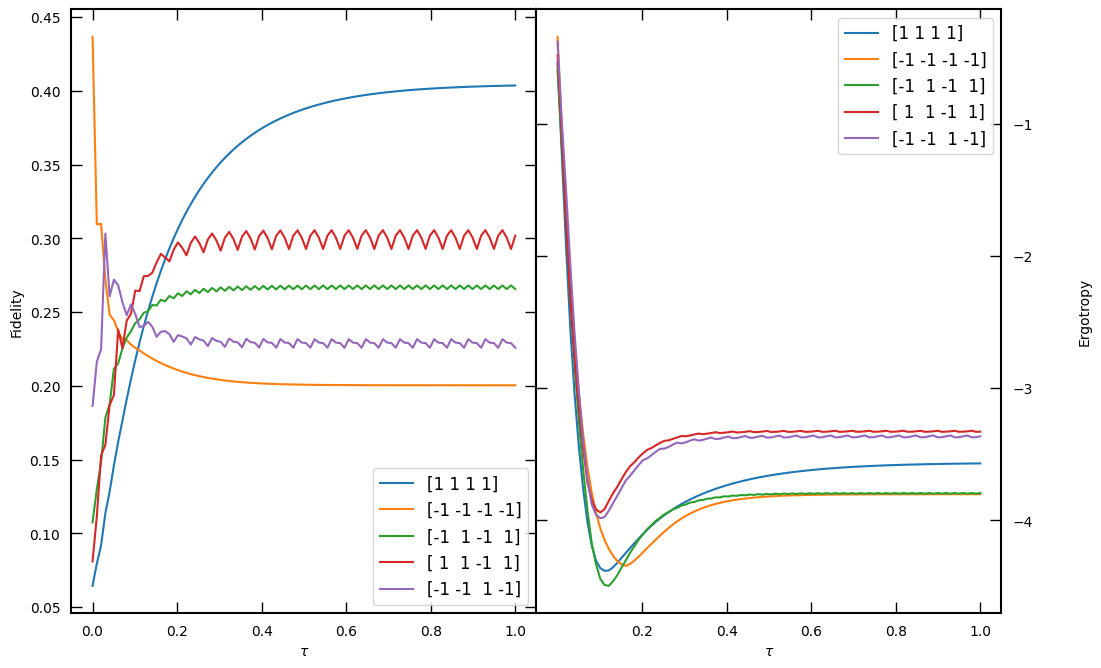

In [27]:
#2-1

N = 6

fidelity21 = np.zeros(shape=(realizations, times))
ergotropy21 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges21= [[0,1,p[0]],[0,2,g[0]],[1,3,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]

    H0 = Isingx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Isingx(N, edges21, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2 = ((i+1)%4+2), ((i+2)%4+2)
        edges21= [[0,1,p[0]],[0,conn_idx1,g[0]],[1,conn_idx2,g[1]],[2,3,J[0]],[3,4,J[1]],[4,5,J[2]],[5,2,J[3]]]
        Htot = Isingx(N, edges21, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy21[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity21[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity21[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy21[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

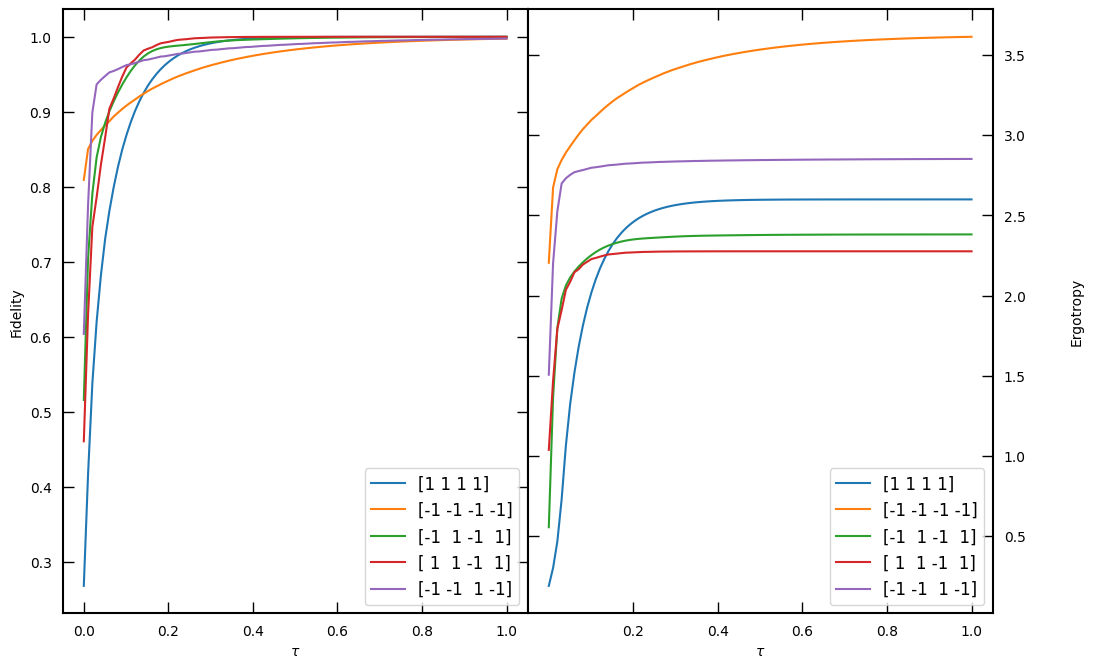

In [6]:
#3-0

N = 7

fidelity30 = np.zeros(shape=(realizations, times))
ergotropy30 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges30= [[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges30, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2, conn_idx3 = ((i+1)%4+3), ((i+2)%4+3), ((i+3)%4+3)
        edges30= [[0,conn_idx1,g[0]],[1,conn_idx2,g[1]],[2,conn_idx3,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
        Htot = Hxxx(N, edges30, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy30[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity30[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity30[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy30[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

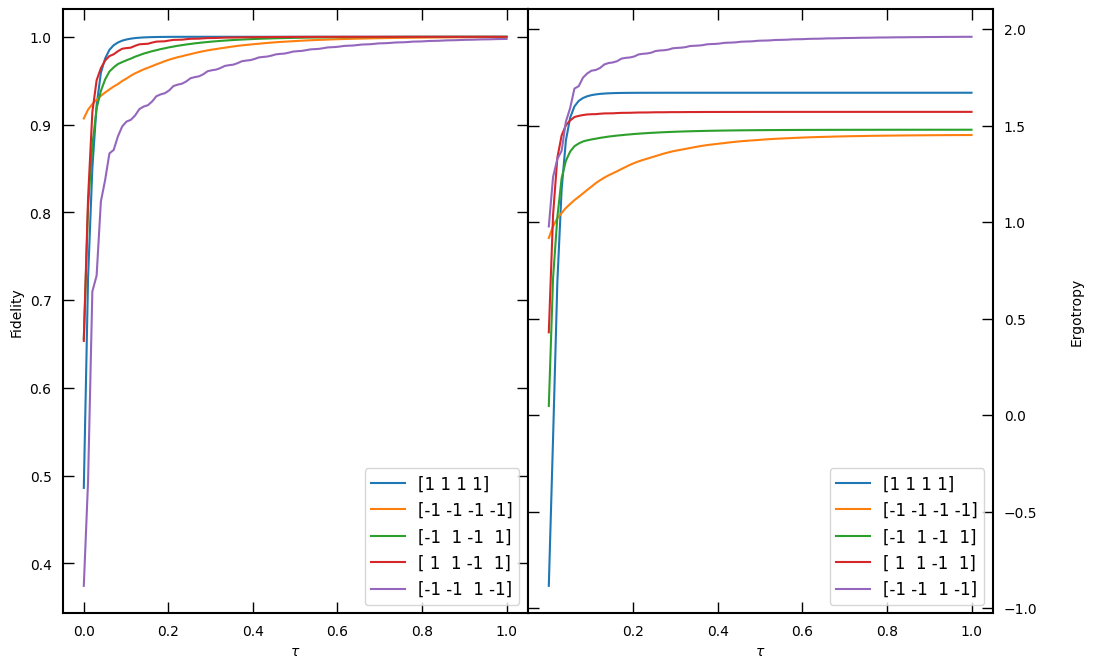

In [24]:
#3-3

N = 7

fidelity33 = np.zeros(shape=(realizations, times))
ergotropy33 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges33= [[0,1,p[0]],[1,2,p[1]],[2,0,p[2]],[0,3,g[0]],[1,4,g[1]],[2,5,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges33, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = np.trace(np.real(Rsyst_red*H0))
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2, conn_idx3 = ((i+1)%4+3), ((i+2)%4+3), ((i+3)%4+3)
        edges33= [[0,1,p[0]],[1,2,p[1]],[2,0,p[2]],[0,conn_idx1,g[0]],[1,conn_idx2,g[1]],[2,conn_idx3,g[2]],[3,4,J[0]],[4,5,J[1]],[5,6,J[2]],[6,3,J[3]]]
        Htot = Hxxx(N, edges33, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy33[r,i] = W0-np.sum(np.real(RsystEigVal*HsystEigEn))
        fidelity33[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity33[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy33[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

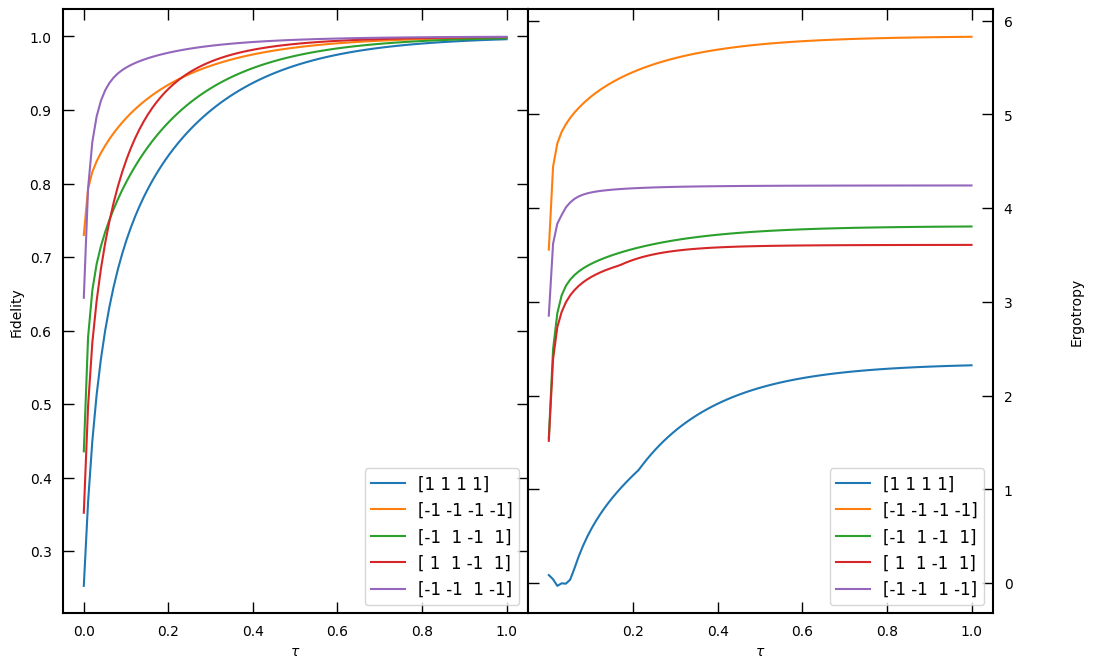

In [25]:
#4-0

N = 8

fidelity40 = np.zeros(shape=(realizations, times))
ergotropy40 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges40= [[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges40, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2, conn_idx3, conn_idx4 = ((i+1)%4+4), ((i+2)%4+4), ((i+3)%4+4), ((i+4)%4+4)
        edges40= [[0,conn_idx1,g[0]],[1,conn_idx2,g[1]],[2,conn_idx3,g[2]],[3,conn_idx4,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]
        Htot = Hxxx(N, edges40, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy40[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity40[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity40[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy40[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

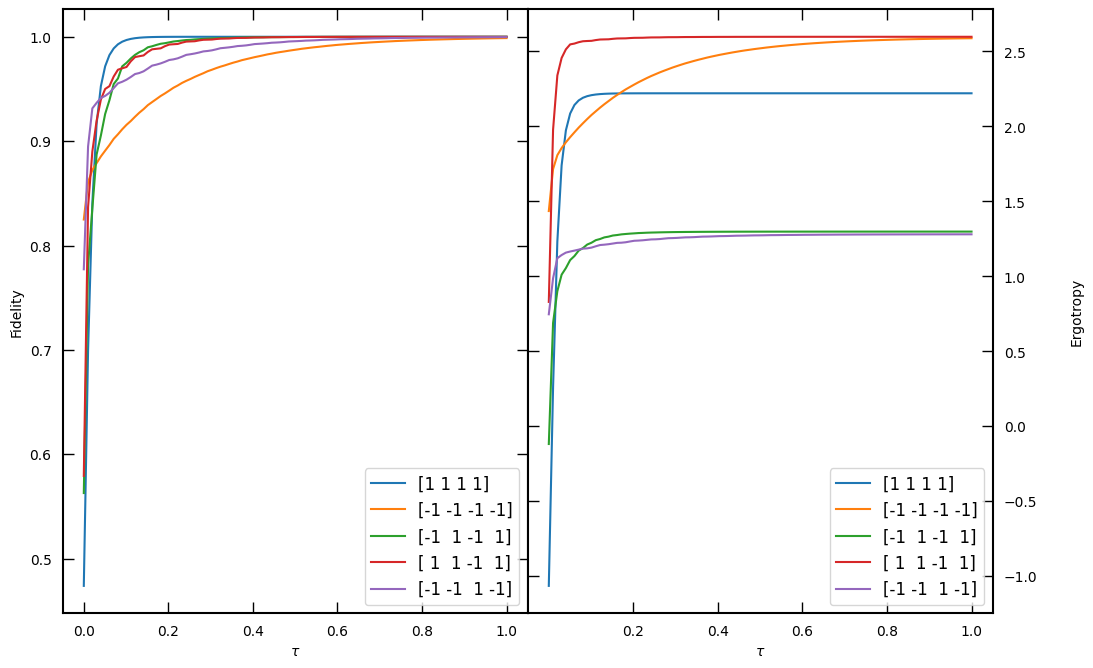

In [26]:
#4-4

N = 8

fidelity44 = np.zeros(shape=(realizations, times))
ergotropy44 = np.zeros(shape=(realizations, times))

for r in range(realizations):
    R = []
    J = Jall[r]

    edges0 = [[0,1,J[0]],[1,2,J[1]],[2,3,J[2]],[3,0,J[3]]]
    edges44= [[0,1,p[0]],[1,2,p[1]],[2,3,p[2]],[3,1,p[3]],[0,4,g[0]],[1,5,g[1]],[2,6,g[2]],[3,7,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]

    H0 = Hxxx(N0, edges0, h=1)
    tracekeep = np.arange((N-N0),N,1)

    Htot = Hxxx(N, edges44, h=1)
    _, gsket = Htot.groundstate()
    Rin = gsket*gsket.dag()
    Rt0 = mesolve(Htot,Rin,t)
    Rtstates0 = Rt0.states[-1].unit()
    Rsyst_red = ptrace(Rtstates0,tracekeep)
    W0 = (Rsyst_red*H0).tr()
    HsystEigEn = H0.eigenenergies(sparse=False, sort='low', eigvals=0, tol=0, maxiter=100000)
    target = excstate(N0)
    target = target*target.dag()
    for i in range(times):
        conn_idx1, conn_idx2, conn_idx3, conn_idx4 = ((i+1)%4+4), ((i+2)%4+4), ((i+3)%4+4), ((i+4)%4+4)
        edges44= [[0,1,p[0]],[1,2,p[1]],[2,3,p[2]],[3,1,p[3]],[0,conn_idx1,g[0]],[1,conn_idx2,g[1]],[2,conn_idx3,g[2]],[3,conn_idx4,g[3]],[4,5,J[0]],[5,6,J[1]],[6,7,J[2]],[7,4,J[3]]]
        Htot = Hxxx(N, edges44, h=1)
        ancilla = excstate(N-N0)
        Rin=tensor(ancilla,Rsyst_red)
        Rt = mesolve(Htot,Rin,t)
        Rtstates = Rt.states[-1].unit()
        Rsyst_red = ptrace(Rtstates,tracekeep).unit()
        RsystEigVal = Rsyst_red.eigenenergies(sparse=False, sort='high', eigvals=0, tol=0, maxiter=100000)
        R.append(Rsyst_red)
        ergotropy44[r,i] =  W0-np.sum(RsystEigVal*HsystEigEn) 
        fidelity44[r,i] = fidelity(target,Rsyst_red)

fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)

for r in range(realizations):
    axs[0].plot(t, fidelity44[r], label = str(Jall[r]))
    axs[1].plot(t, ergotropy44[r], label= str(Jall[r]))
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

In [28]:
charger_names = ['1-0', '2-0', '2-1', '3-0', '3-3', '4-0', '4-4']
fids = np.array([fidelity1, fidelity20, fidelity21, fidelity30, fidelity33, fidelity40, fidelity44])
ergs = np.array([ergotropy1, ergotropy20, ergotropy21, ergotropy30, ergotropy33, ergotropy40, ergotropy44])

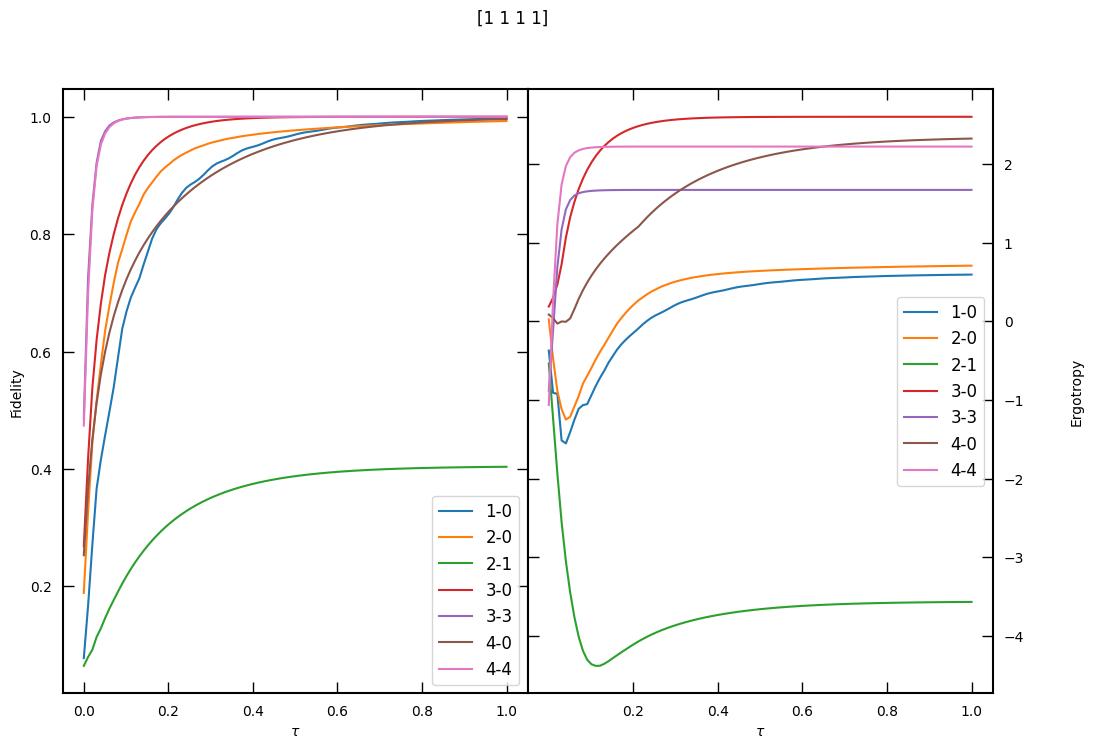

In [29]:
J_idx = 0
fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)
plt.suptitle(str(Jall[J_idx]))

for r in range(len(charger_names)):
    axs[0].plot(t,fids[r,J_idx], label = charger_names[r])
    axs[1].plot(t,ergs[r,J_idx], label = charger_names[r])
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

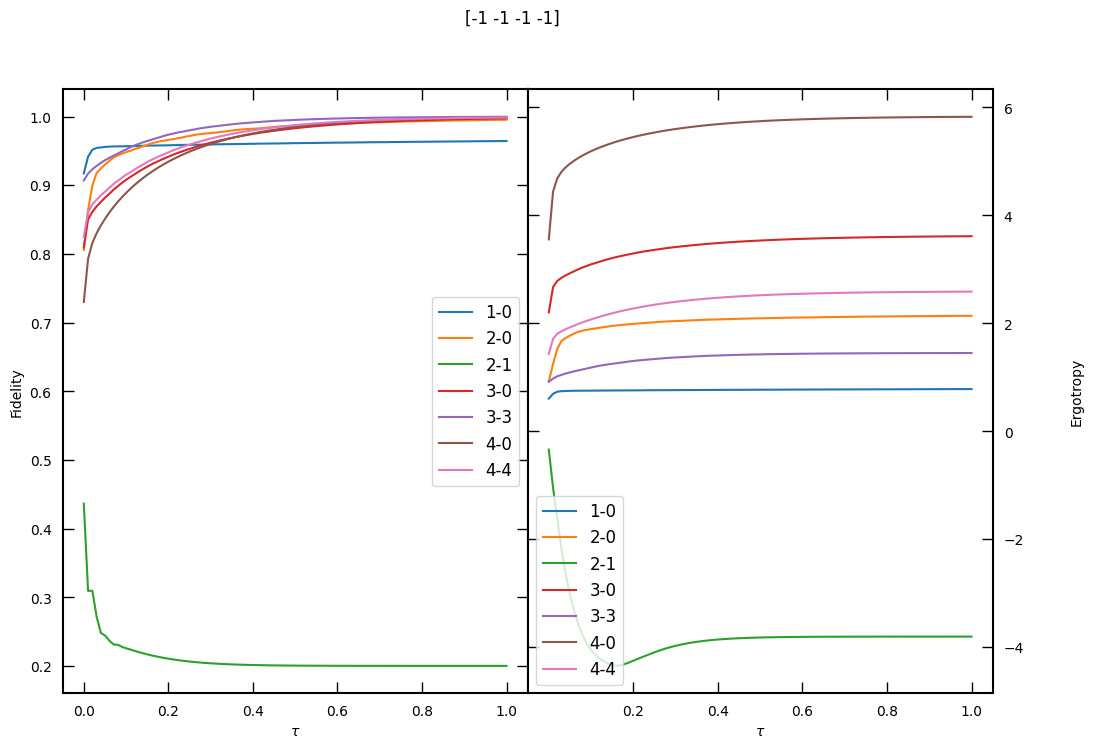

In [30]:
J_idx = 1
fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)
plt.suptitle(str(Jall[J_idx]))

for r in range(len(charger_names)):
    axs[0].plot(t,fids[r,J_idx], label = charger_names[r])
    axs[1].plot(t,ergs[r,J_idx], label= charger_names[r])
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

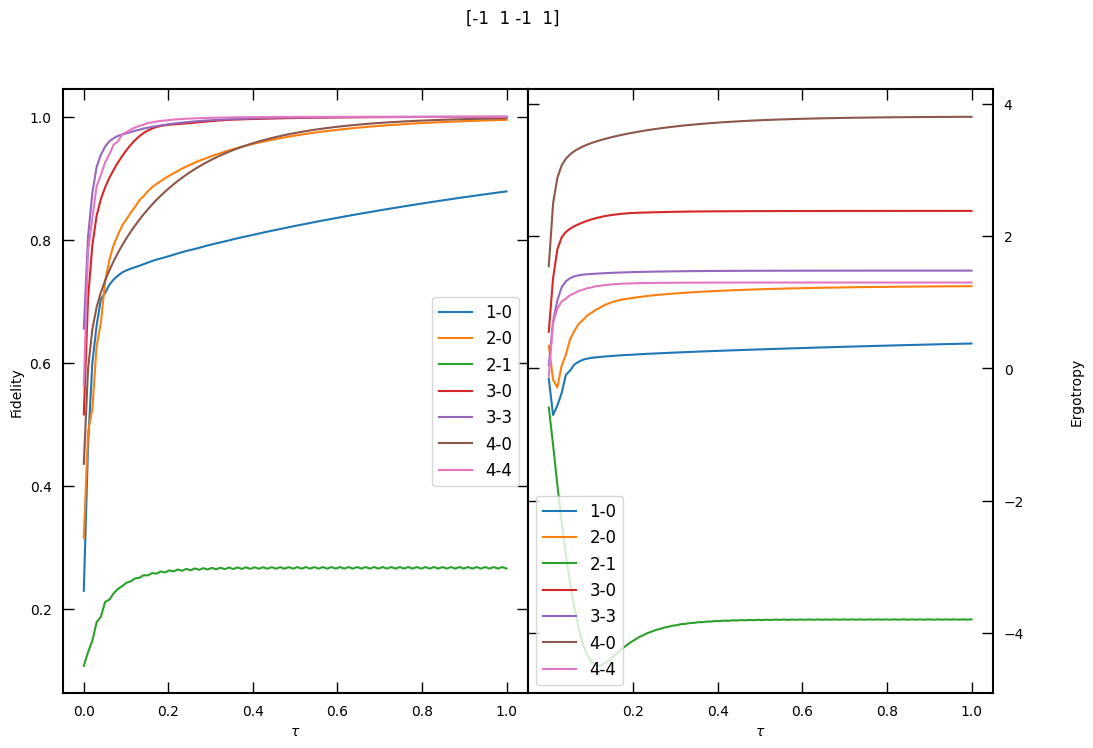

In [31]:
J_idx = 2
fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)
plt.suptitle(str(Jall[J_idx]))

for r in range(len(charger_names)):
    axs[0].plot(t,fids[r,J_idx], label = charger_names[r])
    axs[1].plot(t,ergs[r,J_idx], label= charger_names[r])
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

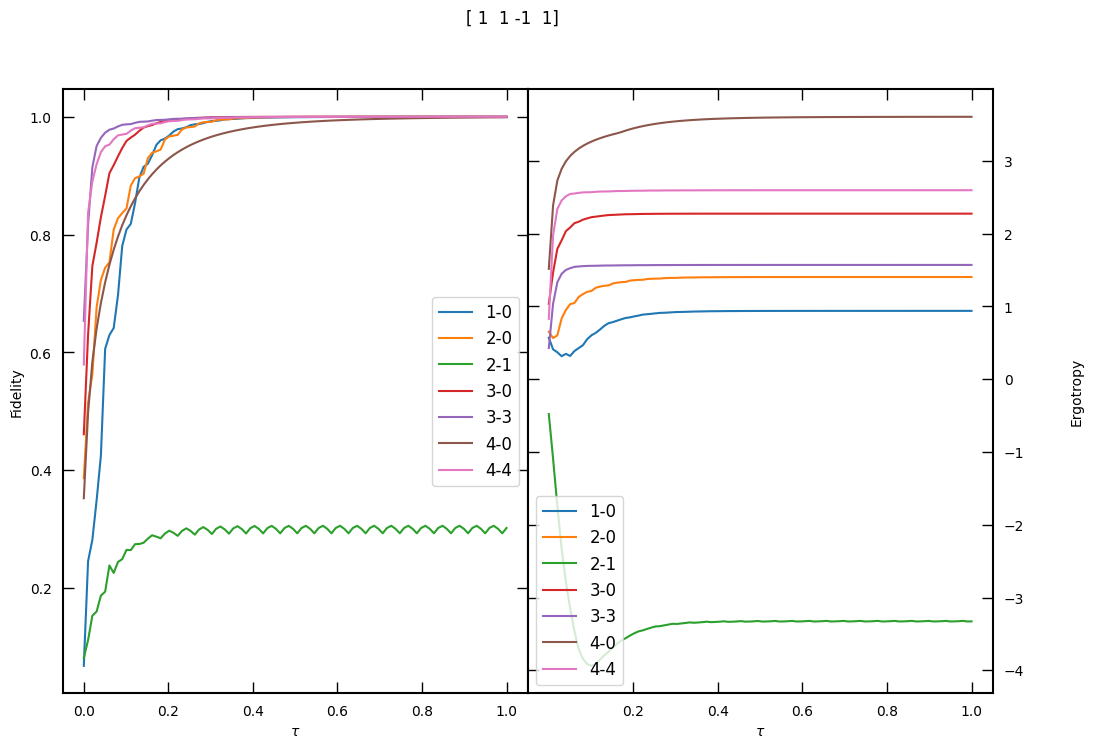

In [32]:
J_idx = 3
fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)
plt.suptitle(str(Jall[J_idx]))

for r in range(len(charger_names)):
    axs[0].plot(t,fids[r,J_idx], label = charger_names[r])
    axs[1].plot(t,ergs[r,J_idx], label= charger_names[r])
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

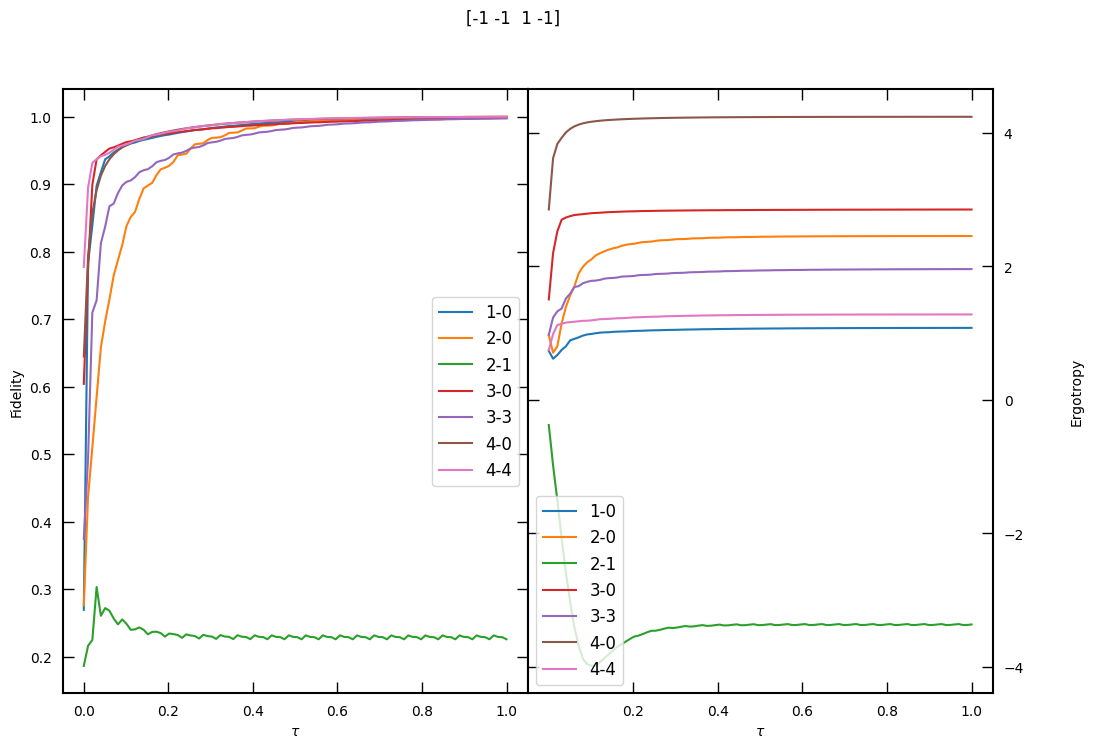

In [33]:
J_idx = 4
fig, axs = plt.subplots(1,2,figsize=(12,8), dpi=100)
plt.subplots_adjust(wspace=0,hspace=0)
plt.suptitle(str(Jall[J_idx]))

for r in range(len(charger_names)):
    axs[0].plot(t,fids[r,J_idx], label = charger_names[r])
    axs[1].plot(t,ergs[r,J_idx], label= charger_names[r])
    axs[0].set_ylabel(r'Fidelity')
    axs[1].set_ylabel(r'Ergotropy',labelpad=-400)

axs[1].set_xticks(axs[1].get_xticks()[2:-1])
axs[1].tick_params(labelleft=False,labelright=True)

for idx in [0,1]:
    axs[idx].legend(fontsize=12)
    axs[idx].set_xlabel('$\\tau$')
    
    for e in ['x', 'y']:
        axs[idx].tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')

In [34]:
deltaW = np.zeros(shape=(len(charger_names), realizations))
for i in range(len(charger_names)):
    for j in range(realizations):
        deltaW[i,j] = (ergs[i,j,-1])-min(ergs[i,j])

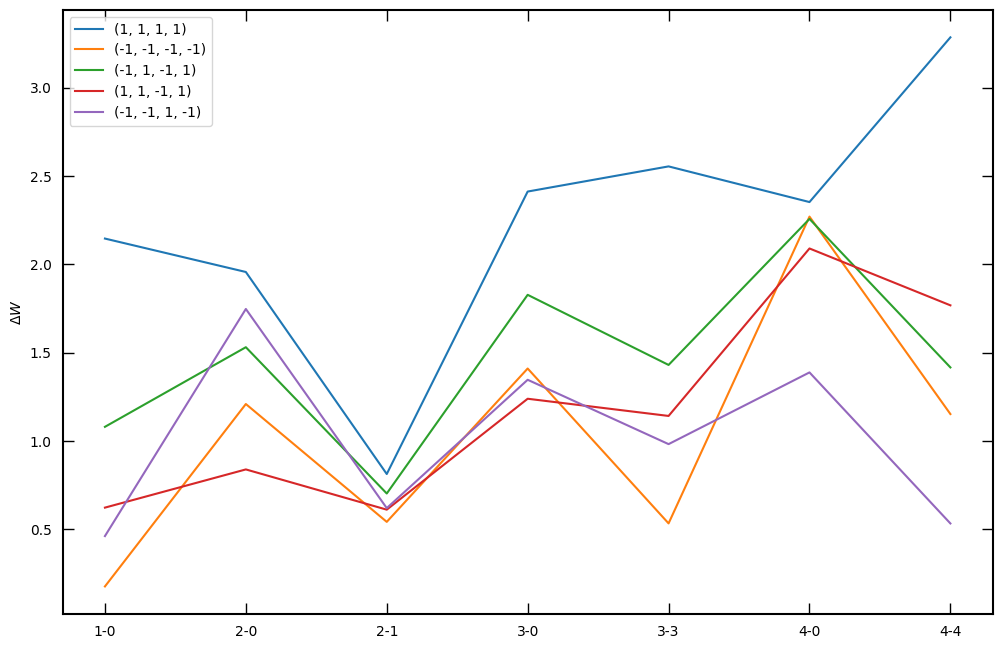

In [35]:
fig, axs = plt.subplots(1,1,figsize=(12,8), dpi=100)

for r in range(realizations):
    axs.plot(np.arange(len(charger_names)), deltaW[::,r], label=str(tuple(Jall[r])))
    axs.set_ylabel(r'$\Delta W$')

axs.legend()
axs.set_xticks(np.arange(len(charger_names)))
axs.set_xticklabels(charger_names)

for e in ['x', 'y']:
    axs.tick_params(axis=e,which='major',size=8,width=1,direction='in',top='on',right='on')